# Crime and Weather-ment

Will certain weather conditions be statistically related to increases in crime?


Notes about weather file:
* Retrieved from https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USC00154958/detail

Notes about crime files: 
* .csv files retrieved from https://data.louisvilleky.gov/
* 'Crime_Data_2003.csv' only has X crimes reported when years 2004-2020 range from ~71,000 to ~91,000 crime reports/year. So, 2003 was left out of the anaylsis
* 'Crime_Data_2019.csv' has reports from 2019-2021


Notes about weather:
* Weather statements (ex: precipitation amounts, min temp) cannot be linked to the exact time of the crime occurence with this data.


In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats

louisville_weather=pd.read_csv("data/2451549.csv") #Weather from 1-1-1997 til 2-9-2021

crime_files = ['Crime_Data_2004.csv', 'Crime_Data_2005.csv', 'Crime_Data_2006.csv','Crime_Data_2007.csv','Crime_Data_2008.csv','Crime_Data_2009.csv','Crime_Data_2010.csv','Crime_Data_2011.csv','Crime_Data_2012.csv','Crime_Data_2013.csv','Crime_Data_2014.csv','Crime_Data_2015.csv','Crime_Data_2016_39.csv','Crime_Data_2017_9.csv', 'Crime_Data_2018.csv' 'Crime_Data_2019.csv']

list_of_crime_dfs = []

for file in crime_files:
    df = pd.read_csv("data/"+file, index_col=None, header=0)
    list_of_crime_dfs.append(df)

concat_crime_df = pd.concat(list_of_crime_dfs, axis=0, ignore_index=True)

# concat_crime_df = concat_crime_df.drop_duplicates(subset=['INCIDENT_NUMBER'])
print("The number of crimes listed: ", len(concat_crime_df), ". Number of unique incident numbers: ", len(concat_crime_df["INCIDENT_NUMBER"].unique()) )

total_counts = concat_crime_df['CRIME_TYPE'].value_counts()
total_counts





The number of rows:  1057486 . Number of unique incident numbers:  1057486


THEFT/LARCENY               208857
ASSAULT                     146584
OTHER                       138979
DRUGS/ALCOHOL VIOLATIONS    122647
BURGLARY                    105148
VEHICLE BREAK-IN/THEFT       95335
VANDALISM                    89776
FRAUD                        51630
MOTOR VEHICLE THEFT          49771
ROBBERY                      23778
SEX CRIMES                    9002
DISTURBING THE PEACE          7805
WEAPONS                       6034
HOMICIDE                      1218
DUI                            649
ARSON                          273
Name: CRIME_TYPE, dtype: int64

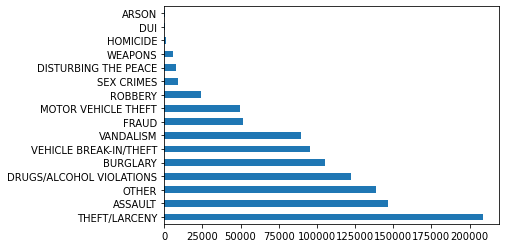

In [2]:
total_counts.plot.barh(x='Number of crimes' )

In [3]:
#Strips the time from date/time
concat_crime_df['DATE_OCCURED_NOTIME'] = concat_crime_df['DATE_OCCURED'].str.split(' ').str[0]
# crime_2019['DATE_OCCURED_NOTIME']
concat_crime_df['Report-Occur-Difference']= pd.to_datetime(concat_crime_df['DATE_REPORTED'].str.split(' ').str[0]) - pd.to_datetime(concat_crime_df['DATE_OCCURED'].str.split(' ').str[0])
# crime_2019
# number = crime_2019['Report-Occur-Difference'].dt.days.sum()
# number = crime_2019['Report-Occur-Difference'].dt.days.max()
# number = crime_2019['Report-Occur-Difference'].dt.days.mode()

concat_crime_df['Report-Occur-Difference'].value_counts()
# crime_2019['Report-Occur-Difference'].barh(x="number")

0 days        696766
1 days        147240
2 days         48413
3 days         25981
4 days         16481
               ...  
1538 days          1
2398 days          1
11168 days         1
3258 days          1
3667 days          1
Name: Report-Occur-Difference, Length: 4296, dtype: int64

In [4]:
louisville_weather['PRCP'].describe()   #describe precipitation column
# louisville_weather['DATE']


count    8803.000000
mean        0.148638
std         0.400267
min         0.000000
25%         0.000000
50%         0.000000
75%         0.070000
max        10.480000
Name: PRCP, dtype: float64

In [5]:
# louisville_weather.describe()
louisville_weather.columns

Index(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'MDPR',
       'MDPR_ATTRIBUTES', 'PRCP', 'PRCP_ATTRIBUTES', 'SNOW', 'SNOW_ATTRIBUTES',
       'SNWD', 'SNWD_ATTRIBUTES', 'TMAX', 'TMAX_ATTRIBUTES', 'TMIN',
       'TMIN_ATTRIBUTES', 'TOBS', 'TOBS_ATTRIBUTES', 'WESD', 'WESD_ATTRIBUTES',
       'WT01', 'WT01_ATTRIBUTES', 'WT03', 'WT03_ATTRIBUTES', 'WT04',
       'WT04_ATTRIBUTES', 'WT05', 'WT05_ATTRIBUTES', 'WT06', 'WT06_ATTRIBUTES',
       'WT11', 'WT11_ATTRIBUTES'],
      dtype='object')

In [11]:
date_crime_count_df = louisville_weather[['DATE','PRCP','SNOW','TMAX','TMIN']].iloc[2191:8766]
date_crime_count_df['DOW'] = pd.to_datetime(date_crime_count_df['DATE']).dt.day_name()
date_crime_count_df['DOW-N'] = pd.to_datetime(date_crime_count_df['DATE']).dt.dayofweek  #DOW-Number 0=Monday, 1=Tuesday...

date_crime_count_df['Day'] = pd.to_datetime(date_crime_count_df['DATE']).dt.day
date_crime_count_df['Month'] = pd.to_datetime(date_crime_count_df['DATE']).dt.month
date_crime_count_df['Year'] = pd.to_datetime(date_crime_count_df['DATE']).dt.year


date_crime_count_df

,DATE,PRCP,SNOW,TMAX,TMIN,DOW,DOW-N,Day,Month,Year
2191,2003-01-01,0.61,0.0,46.0,33.0,Wednesday,2,1,1,2003
2192,2003-01-02,0.28,1.1,36.0,31.0,Thursday,3,2,1,2003
2193,2003-01-03,0.01,0.1,31.0,27.0,Friday,4,3,1,2003
2194,2003-01-04,0.00,0.0,37.0,22.0,Saturday,5,4,1,2003
2195,2003-01-05,0.00,0.0,44.0,36.0,Sunday,6,5,1,2003
...,...,...,...,...,...,...,...,...,...,...
8761,2020-12-27,0.00,0.0,57.0,30.0,Sunday,6,27,12,2020
8762,2020-12-28,0.00,0.0,53.0,28.0,Monday,0,28,12,2020
8763,2020-12-29,0.00,0.0,39.0,29.0,Tuesday,1,29,12,2020
8764,2020-12-30,1.00,0.0,58.0,34.0,Wednesday,2,30,12,2020


In [12]:
import time
start = time.time()

#Take all of the crime types for the day, count them, and put them in a series to be connected to the specific day
crime_series=[]
assault_series=[]
theft_series=[]
other_series=[]
drugs_series=[]
vehicle_break_series=[]
vandalism_series=[]
burglary_series=[]
motor_vehicle_theft_series=[]
fraud_series=[]
robbery_series=[]
weapons_series=[]
sex_crimes_series=[]
disturbing_peace_series=[]
homicide_series=[]
arson_series=[]
dui_series=[]
 
for date in date_crime_count_df['DATE']:
    crime_series.append((concat_crime_df['DATE_OCCURED_NOTIME']==date).sum())
    assault_series.append(len(concat_crime_df[(concat_crime_df['CRIME_TYPE']=="ASSAULT") & (concat_crime_df['DATE_OCCURED_NOTIME']==date)]))
    theft_series.append(len(concat_crime_df[(concat_crime_df['CRIME_TYPE']=="THEFT/LARCENY") & (concat_crime_df['DATE_OCCURED_NOTIME']==date)]))
    other_series.append(len(concat_crime_df[(concat_crime_df['CRIME_TYPE']=="OTHER") & (concat_crime_df['DATE_OCCURED_NOTIME']==date)]))
    drugs_series.append(len(concat_crime_df[(concat_crime_df['CRIME_TYPE']=="DRUGS/ALCOHOL VIOLATIONS") & (concat_crime_df['DATE_OCCURED_NOTIME']==date)]))
    vehicle_break_series.append(len(concat_crime_df[(concat_crime_df['CRIME_TYPE']=="VEHICLE BREAK-IN/THEFT") & (concat_crime_df['DATE_OCCURED_NOTIME']==date)]))
    vandalism_series.append(len(concat_crime_df[(concat_crime_df['CRIME_TYPE']=="VANDALISM") & (concat_crime_df['DATE_OCCURED_NOTIME']==date)]))
    burglary_series.append(len(concat_crime_df[(concat_crime_df['CRIME_TYPE']=="BURGLARY") & (concat_crime_df['DATE_OCCURED_NOTIME']==date)]))
    motor_vehicle_theft_series.append(len(concat_crime_df[(concat_crime_df['CRIME_TYPE']=="MOTOR VEHICLE THEFT") & (concat_crime_df['DATE_OCCURED_NOTIME']==date)]))
    fraud_series.append(len(concat_crime_df[(concat_crime_df['CRIME_TYPE']=="FRAUD") & (concat_crime_df['DATE_OCCURED_NOTIME']==date)]))
    robbery_series.append(len(concat_crime_df[(concat_crime_df['CRIME_TYPE']=="ROBBERY") & (concat_crime_df['DATE_OCCURED_NOTIME']==date)]))
    weapons_series.append(len(concat_crime_df[(concat_crime_df['CRIME_TYPE']=="WEAPONS") & (concat_crime_df['DATE_OCCURED_NOTIME']==date)]))
    sex_crimes_series.append(len(concat_crime_df[(concat_crime_df['CRIME_TYPE']=="SEX CRIMES") & (concat_crime_df['DATE_OCCURED_NOTIME']==date)]))
    disturbing_peace_series.append(len(concat_crime_df[(concat_crime_df['CRIME_TYPE']=="DISTURBING THE PEACE") & (concat_crime_df['DATE_OCCURED_NOTIME']==date)]))
    homicide_series.append(len(concat_crime_df[(concat_crime_df['CRIME_TYPE']=="HOMICIDE") & (concat_crime_df['DATE_OCCURED_NOTIME']==date)]))
    arson_series.append(len(concat_crime_df[(concat_crime_df['CRIME_TYPE']=="ARSON") & (concat_crime_df['DATE_OCCURED_NOTIME']==date)]))
    dui_series.append(len(concat_crime_df[(concat_crime_df['CRIME_TYPE']=="DUI") & (concat_crime_df['DATE_OCCURED_NOTIME']==date)]))
 
 
# print(sum(dui_series))
# print(sum(arson_series))
# print(sum(homicide_series))
end = time.time()
print(end - start) 



15943.468366146088


In [35]:
print("The previous cell took: ", (end-start)/60, " minutes to run.")

The previous cell took:  265.72447276910145  minutes to run.


In [13]:
date_crime_count_df['NUMBER_OF_CRIMES'] = crime_series
date_crime_count_df['ASSAULT'] = assault_series
date_crime_count_df['THEFT'] = theft_series
date_crime_count_df['OTHER'] = other_series
date_crime_count_df['DRUGS'] = drugs_series
date_crime_count_df['VEHICLE BREAKINS'] = vehicle_break_series
date_crime_count_df['VANDALISM'] = vandalism_series
date_crime_count_df['BURGLARY'] = burglary_series
date_crime_count_df['MOTOR VEHICLE THEFT'] = motor_vehicle_theft_series
date_crime_count_df['FRAUD'] = fraud_series
date_crime_count_df['ROBBERY'] = robbery_series
date_crime_count_df['WEAPONS'] = weapons_series
date_crime_count_df['SEX CRIMES'] = sex_crimes_series
date_crime_count_df['DISTURBING PEACE'] = disturbing_peace_series
date_crime_count_df['HOMICIDE'] = homicide_series
date_crime_count_df['ARSON'] = arson_series
date_crime_count_df['DUI'] = dui_series



In [14]:
date_crime_count_df

,DATE,PRCP,SNOW,TMAX,TMIN,DOW,DOW-N,Day,Month,Year,...,BURGLARY,MOTOR VEHICLE THEFT,FRAUD,ROBBERY,WEAPONS,SEX CRIMES,DISTURBING PEACE,HOMICIDE,ARSON,DUI
2191,2003-01-01,0.61,0.0,46.0,33.0,Wednesday,2,1,1,2003,...,0,0,28,0,0,43,1,0,0,0
2192,2003-01-02,0.28,1.1,36.0,31.0,Thursday,3,2,1,2003,...,0,0,7,0,0,10,0,0,0,0
2193,2003-01-03,0.01,0.1,31.0,27.0,Friday,4,3,1,2003,...,0,0,0,0,0,0,0,0,0,0
2194,2003-01-04,0.00,0.0,37.0,22.0,Saturday,5,4,1,2003,...,0,0,0,0,0,0,0,0,0,0
2195,2003-01-05,0.00,0.0,44.0,36.0,Sunday,6,5,1,2003,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8761,2020-12-27,0.00,0.0,57.0,30.0,Sunday,6,27,12,2020,...,5,11,3,2,2,1,1,1,0,0
8762,2020-12-28,0.00,0.0,53.0,28.0,Monday,0,28,12,2020,...,9,13,10,6,2,0,1,0,1,0
8763,2020-12-29,0.00,0.0,39.0,29.0,Tuesday,1,29,12,2020,...,10,21,8,2,2,0,0,1,0,0
8764,2020-12-30,1.00,0.0,58.0,34.0,Wednesday,2,30,12,2020,...,11,13,5,0,2,0,0,2,0,0


In [15]:
date_crime_count_df['DOW'] = date_crime_count_df['DOW'].astype(str)

In [16]:
print(date_crime_count_df.dtypes)

DATE                    object
PRCP                   float64
SNOW                   float64
TMAX                   float64
TMIN                   float64
DOW                     object
DOW-N                    int64
Day                      int64
Month                    int64
Year                     int64
NUMBER_OF_CRIMES         int64
ASSAULT                  int64
THEFT                    int64
OTHER                    int64
DRUGS                    int64
VEHICLE BREAKINS         int64
VANDALISM                int64
BURGLARY                 int64
MOTOR VEHICLE THEFT      int64
FRAUD                    int64
ROBBERY                  int64
WEAPONS                  int64
SEX CRIMES               int64
DISTURBING PEACE         int64
HOMICIDE                 int64
ARSON                    int64
DUI                      int64
dtype: object


In [17]:
# date_crime_count_df['PRCP'].describe()
zero_days = (date_crime_count_df['PRCP']==0).sum()
nonzero_days = (date_crime_count_df['PRCP']>0).sum()
print("Number of days with no precipitation: ",zero_days, " - Percentage: ", zero_days/(zero_days+nonzero_days))  # How many zeros are there
print("Number of days with some precipitation: ", nonzero_days, " - Percentage: ", nonzero_days/(zero_days+nonzero_days))
print("Number of days with snow: ", (date_crime_count_df['SNOW']>0).sum())

Number of days with no precipitation:  4105  - Percentage:  0.6245245702114711
Number of days with some precipitation:  2468  - Percentage:  0.3754754297885288
Number of days with snow:  264


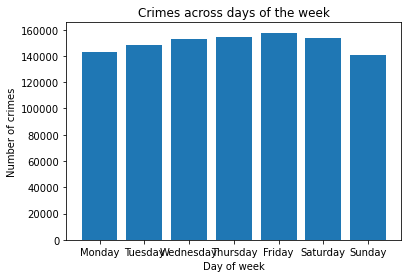

In [18]:
monday_crimes = date_crime_count_df.loc[date_crime_count_df['DOW'] == 'Monday', 'NUMBER_OF_CRIMES'].sum()
tuesday_crimes = date_crime_count_df.loc[date_crime_count_df['DOW'] == 'Tuesday', 'NUMBER_OF_CRIMES'].sum()
wednesday_crimes = date_crime_count_df.loc[date_crime_count_df['DOW'] == 'Wednesday', 'NUMBER_OF_CRIMES'].sum()
thursday_crimes = date_crime_count_df.loc[date_crime_count_df['DOW'] == 'Thursday', 'NUMBER_OF_CRIMES'].sum()
friday_crimes = date_crime_count_df.loc[date_crime_count_df['DOW'] == 'Friday', 'NUMBER_OF_CRIMES'].sum()
saturday_crimes = date_crime_count_df.loc[date_crime_count_df['DOW'] == 'Saturday', 'NUMBER_OF_CRIMES'].sum()
sunday_crimes = date_crime_count_df.loc[date_crime_count_df['DOW'] == 'Sunday', 'NUMBER_OF_CRIMES'].sum()


x = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
DOW = [monday_crimes, tuesday_crimes, wednesday_crimes, thursday_crimes, friday_crimes, saturday_crimes, sunday_crimes]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, DOW)
plt.xlabel("Day of week")
plt.ylabel("Number of crimes")
plt.title("Crimes across days of the week")

plt.xticks(x_pos, x)

plt.show()


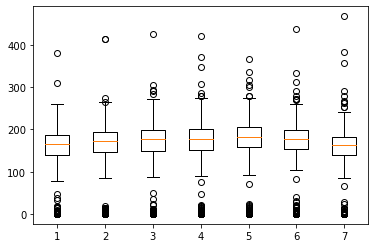

In [19]:
DOW=[]
DOWList=['Monday', 'Tuesday','Wednesday', 'Thursday','Friday','Saturday', 'Sunday']
for x in DOWList:
    DOW.append(date_crime_count_df.loc[date_crime_count_df['DOW'] == x, 'NUMBER_OF_CRIMES'])

averageCrimesOnDOM= plt.boxplot(DOW)

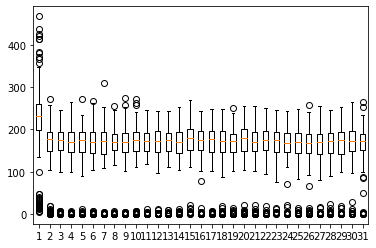

In [20]:
DOM=[]
for x in range(1,32):
    DOM.append(date_crime_count_df.loc[date_crime_count_df['Day'] == x, 'NUMBER_OF_CRIMES'])


averageCrimesOnDOM= plt.boxplot(DOM)



In [22]:
DOM=[]
for x in range(1,32):
    DOM.append(date_crime_count_df.loc[date_crime_count_df['Day'] == x & date_crime_count_df['D'] == x, 'NUMBER_OF_CRIMES'])


averageCrimesOnDOM= plt.boxplot(DOM)

KeyError: 'D'

In [107]:
#Do we still get the same unequal distribution when we limit large differences in report vs occurrence dates

MOY=[]
for x in range(1,13):
    MOY.append(date_crime_count_df.loc[date_crime_count_df['Month'] == x & date_crime_count_df['Report-Occur-Difference']<7, 'NUMBER_OF_CRIMES'])


averageCrimesOnMOY= plt.boxplot(MOY)



KeyError: 'Report-Occur-Difference'

[52718, 57655, 63509, 68958, 69924, 68256, 72597, 74931, 69729, 65559, 65260, 67125, 69562, 65552, 59437, 57087]


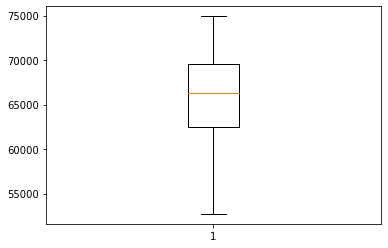

In [23]:
Year=[]
yearList=[2004,2005,2006,2007,2008,2009,2010,2011,2012, 2013,2014,2015,2016,2017,2019,2020]
for x in yearList:
    Year.append(date_crime_count_df.loc[date_crime_count_df['Year'] == x, 'NUMBER_OF_CRIMES'].sum())

print(Year)

averageCrimesOnYear= plt.boxplot(Year)

KeyError: 'Year'

.00-.19 “very weak”

.20-.39 “weak”

.40-.59 “moderate”

.60-.79 “strong”

.80-1.0 “very strong”


In [24]:
#What is the correlation between precipitation amounts and number of crimes per day
print(stats.pearsonr(date_crime_count_df['PRCP'],date_crime_count_df['NUMBER_OF_CRIMES']))
#precipitation/crimes
date_crime_count_df.plot(x='PRCP', y='NUMBER_OF_CRIMES', kind='scatter', )

ValueError: array must not contain infs or NaNs

In [25]:
#What is the correlation between snow amounts and number of crimes per day
print(stats.pearsonr(date_crime_count_df['SNOW'],date_crime_count_df['NUMBER_OF_CRIMES']))
#Scatter plot for snow and number of crimes
date_crime_count_df.plot(x='SNOW', y='NUMBER_OF_CRIMES', kind='scatter', color='green', )

ValueError: array must not contain infs or NaNs

(0.16166786587556453, 9.571099539665766e-40)


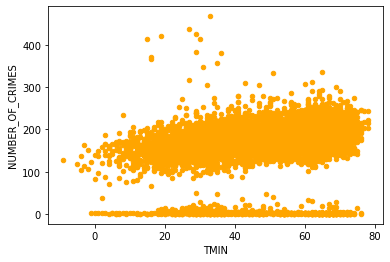

In [26]:
#What is the correlation between TMIN and number of crimes per day
print(stats.pearsonr(date_crime_count_df['TMIN'],date_crime_count_df['NUMBER_OF_CRIMES']))
date_crime_count_df.plot(x='TMIN', y='NUMBER_OF_CRIMES', kind='scatter', color='orange', )

(0.1872393162170325, 6.042838602546251e-53)


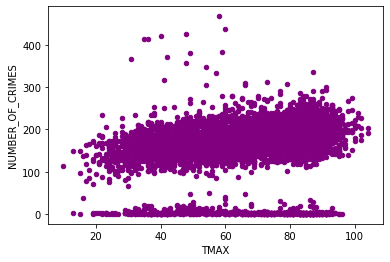

In [27]:
#What is the correlation between TMAX and number of crimes per day
print(stats.pearsonr(date_crime_count_df['TMAX'],date_crime_count_df['NUMBER_OF_CRIMES']))
date_crime_count_df.plot(x='TMAX', y='NUMBER_OF_CRIMES', kind='scatter', color='purple', )

(0.20848864227615382, 1.7464715511910409e-65)


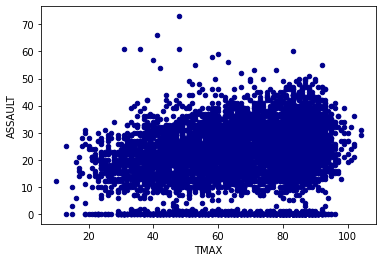

In [28]:
#What is the correlation between TMAX and number of assaults per day
print(stats.pearsonr(date_crime_count_df['TMAX'],date_crime_count_df['ASSAULT']))
date_crime_count_df.plot(x='TMAX', y='ASSAULT', kind='scatter', color='darkblue', )

In [29]:
#What is the correlation between Precipitation and assaults per day
print(stats.pearsonr(date_crime_count_df['PRCP'],date_crime_count_df['ASSAULT']))
date_crime_count_df.plot(x='PRCP', y='ASSAULT', kind='scatter', color='aqua', )

ValueError: array must not contain infs or NaNs

In [30]:
#What is the correlation between Precipitation and arsons per day
print(stats.pearsonr(date_crime_count_df['PRCP'],date_crime_count_df['ARSON']))
date_crime_count_df.plot(x='PRCP', y='ARSON', kind='scatter', color='red', )

ValueError: array must not contain infs or NaNs

In [31]:
#What is the correlation between Precipitation and Homicides per day
print(stats.pearsonr(date_crime_count_df['PRCP'],date_crime_count_df['HOMICIDE']))
date_crime_count_df.plot(x='PRCP', y='HOMICIDE', kind='scatter', color='grey', )

ValueError: array must not contain infs or NaNs

In [32]:
#What is the correlation between Precipitation and vandalisms per day
print(stats.pearsonr(date_crime_count_df['PRCP'],date_crime_count_df['VANDALISM']))
date_crime_count_df.plot(x='PRCP', y='VANDALISM', kind='scatter', color='black', )

ValueError: array must not contain infs or NaNs

In [33]:
#What is the correlation between Precipitation and robbery per day
print(stats.pearsonr(date_crime_count_df['PRCP'],date_crime_count_df['ROBBERY']))
date_crime_count_df.plot(x='ROBBERY', y='PRCP', kind='bar', color='black', )

ValueError: array must not contain infs or NaNs